# Drawing prevalence of disease combinations of interest and odds ratio
- Figure 2c–f
- Figure 3
- Supplementary Figure 1

In [1]:
import pandas as pd
import time
import os
import glob
import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib_venn
from matplotlib_venn import venn3,venn3_circles,venn2,venn2_circles
import numpy as np
import seaborn as sns


print("pandas",pd.__version__)
print("numpy",np.__version__)
print("matplotlib",mpl.__version__)
print("matplotlib_venn",matplotlib_venn.__version__)
print("seaborn",sns.__version__)

### setup ###
# Data Directory
current_path = "/Users/chidakatsuyuki/Desktop/Project/Codes_for_NS_article/"
output_image_dir = current_path +"NephroticSyndrome_image/"
if not os.path.exists(output_image_dir):
    os.mkdir(output_image_dir)

mpl.style.use("default")
mpl.rcParams["font.family"] = "Arial"
mpl.rcParams["pdf.fonttype"] = 42 
mpl.rcParams['ps.fonttype'] = 42

pandas 1.3.4
numpy 1.22.4
matplotlib 3.6.3
matplotlib_venn 0.11.7
seaborn 0.11.2


In [2]:
# Enrolle IDs in each group and target disease diagnosis date
df_p=pd.read_csv(current_path+"NephroticSyndrome_csv/patient/Group_diseases.csv")
df_c=pd.read_csv(current_path+"NephroticSyndrome_csv/control/Group_diseases.csv")

In [3]:
import itertools
def Set_First_Diag_Point(df_p: pd.DataFrame,
                         df_c: pd.DataFrame,
                        )->pd.DataFrame:
    
    
    
    """
    Set_First_Diag_Point
        This function makes dataframe indicating diagnosis experiences of code, ["I10", "E79", "E78", "J30", "L30"].
        Input
            df_p,df_c : Group's dataframe including ["Enrollee ID","ICD10_3_Code","Months_from_target_diag","To_observation_end","Target"]
        Output
            pd.DataFrame
    """
    
    df = pd.concat([df_p,df_c])

    
    # To the observation start from target diagnosis
    df["To_observation_start"]= pd.to_datetime(df["Observation_start_yyyymm"],format='%Y%m').dt.to_period('M').view('int')-pd.to_datetime(
                                            df["Target_diag_yyyymm"],format='%Y%m').dt.to_period('M').view('int')
    # To the observation end from target diagnosis
    df["To_observation_end"] = pd.to_datetime(df["Observation_end_yyyymm"],format='%Y%m').dt.to_period('M').view('int')-pd.to_datetime(
                                            df["Target_diag_yyyymm"],format='%Y%m').dt.to_period('M').view('int')
    # Set time_points
    time_points = np.arange(start =df["To_observation_start"].min(),stop=df["To_observation_end"].max()+1)
    
    
    df["Months_from_target_diag"] = pd.to_datetime(df["Record_yyyymm"],format='%Y%m').dt.to_period('M').view('int')-pd.to_datetime(
                                            df["Target_diag_yyyymm"],format='%Y%m').dt.to_period('M').view('int')
    
    
    # Codes included in combinations of interest
    codes = ["I10", "E79", "E78", "J30", "L30"]
    
    # We used first diagnosis to calculate a cumnulative prevalence
    df_temp = df[["Enrollee ID","ICD10_3_Code","Months_from_target_diag","To_observation_end","Target"]].copy()
    df_temp.sort_values(by = "Months_from_target_diag",kind="mergesort",ascending=True, inplace=True)
    df_temp.drop_duplicates(subset=["Enrollee ID","ICD10_3_Code"],keep="first", inplace=True)
    # Extract diseases of interest
    df_temp = df_temp[df_temp["ICD10_3_Code"].isin(codes)]

    # Multi-level for counting 
    # We made a column for each code and each ID, which was set up with a hierarchy of groups
    array = [x for x in itertools.product(["Control"],codes,df_c["Enrollee ID"].drop_duplicates())
            ] + [x for x in itertools.product(["Case"],codes,df_p["Enrollee ID"].drop_duplicates())
                ]
    column = pd.MultiIndex.from_tuples(array, names=["Group", "Disease", "ID"])
    # Dataframe for counting
    df_count = pd.DataFrame(index=time_points,columns=column)

    # Label firts diagnosis point of each disease
    for group in ["Control", "Case"]:
        # Extract group data
        if group == "Control":
            df_group_temp = df_temp[df_temp["Target"]==0]
        elif group == "Case":
            df_group_temp = df_temp[df_temp["Target"]==1]

        for code in codes:
            df_code_temp = df_group_temp.loc[(df_group_temp["ICD10_3_Code"]==code)].copy()

            for row in df_code_temp.iterrows():
                # Diagnosed timepoint
                df_count.loc[row[1]["Months_from_target_diag"],(group,code,row[1]["Enrollee ID"])]=1
                # Observation end timepoint
                df_count.loc[row[1]["To_observation_end"],(group,code,row[1]["Enrollee ID"])]=0


    # Label timepoints from diagnosed, to observation end
    df_count.ffill(inplace = True)
    df_count.fillna(0,inplace = True)
    return df_count

df_count = Set_First_Diag_Point(df_p,df_c)

In [4]:
# Combinations of interest
code2 = ["I10*E78*E79", "E78*E79", "I10*E78", "I10*E79", "L30*J30"]

# Set time points during observation period
time_points = df_count.index
    
# For combination
array = [x for x in itertools.product(["Control"],code2,df_c["Enrollee ID"].drop_duplicates())
        ] + [x for x in itertools.product(["Case"],code2,df_p["Enrollee ID"].drop_duplicates())
            ]
column = pd.MultiIndex.from_tuples(array, names=["Group", "Disease", "ID"])
# Dataframe for counting
df_comb = pd.DataFrame(index=time_points,columns=column)

# Count each combination of interest
for group in ["Control", "Case"]:
    if group == "Control":
        idx = df_c["Enrollee ID"].drop_duplicates()      
    elif group == "Case":
        idx = df_p["Enrollee ID"].drop_duplicates()  
    for i in idx:
        df_comb.loc[:,(group,"L30*J30",i)]=df_count.loc[:,(group,"L30",i)]*df_count.loc[:,(group,"J30",i)]
        df_comb.loc[:,(group,"I10*E79",i)]=df_count.loc[:,(group,"I10",i)]*df_count.loc[:,(group,"E79",i)]
        df_comb.loc[:,(group,"I10*E78",i)]=df_count.loc[:,(group,"I10",i)]*df_count.loc[:,(group,"E78",i)]
        df_comb.loc[:,(group,"E78*E79",i)]=df_count.loc[:,(group,"E78",i)]*df_count.loc[:,(group,"E79",i)]
        df_comb.loc[:,(group,"I10*E78*E79",i)]=df_count.loc[:,(group,"I10",i)]*df_comb.loc[:,(group,"E78*E79",i)]

In [5]:
# Counts individuals at time_points for a calculation of ratio
df = pd.concat([df_p,df_c])
# To the observation start from target diagnosis
df["To_observation_start"]= pd.to_datetime(df["Observation_start_yyyymm"],format='%Y%m').dt.to_period('M').view('int')-pd.to_datetime(
                                        df["Target_diag_yyyymm"],format='%Y%m').dt.to_period('M').view('int')
# To the observation end from target diagnosis
df["To_observation_end"] = pd.to_datetime(df["Observation_end_yyyymm"],format='%Y%m').dt.to_period('M').view('int')-pd.to_datetime(
                                        df["Target_diag_yyyymm"],format='%Y%m').dt.to_period('M').view('int')
# Individual observation period
df_temp = df.copy()
df_temp =df_temp[['Enrollee ID','Target','To_observation_start', 'To_observation_end']].drop_duplicates()

case_con = {"Control":0, "Case":1}

df_obsnum = pd.DataFrame(data = {"Time_point":time_points})
for key in case_con.keys():
    for i in range(len(df_obsnum)-1):
        start_mask = (df_temp["Target"]==case_con[key])&(df_temp["To_observation_start"]<=df_obsnum.loc[i, "Time_point"])
        end_mask = (df_temp["Target"]==case_con[key])&(df_obsnum.loc[i+1, "Time_point"]<=df_temp["To_observation_end"])
        df_obsnum.loc[i, f"{key}"] = (start_mask&end_mask).sum()

    end_mask = (df_temp["Target"]==case_con[key])&(df_obsnum.loc[len(df_obsnum)-1, "Time_point"] <= df_temp["To_observation_end"])
    df_obsnum.loc[len(df_obsnum)-1, f"{key}"] = end_mask.sum()
df_obsnum.set_index("Time_point",inplace=True)

In [6]:
# Aggregate counts and then concatenate two dataframes
df_total = pd.concat([df_count.T.groupby(level=("Group","Disease")).agg(sum),
                      df_comb.T.groupby(level=("Group","Disease")).agg(sum)]).sort_index()

# Calculate ratios along with time
df_ratio = pd.concat([df_total.loc["Case"]/df_obsnum["Case"],
                      df_total.loc["Control"]/df_obsnum["Control"]],keys=("Case","Control")).T

## Drawing cumulative prevalence

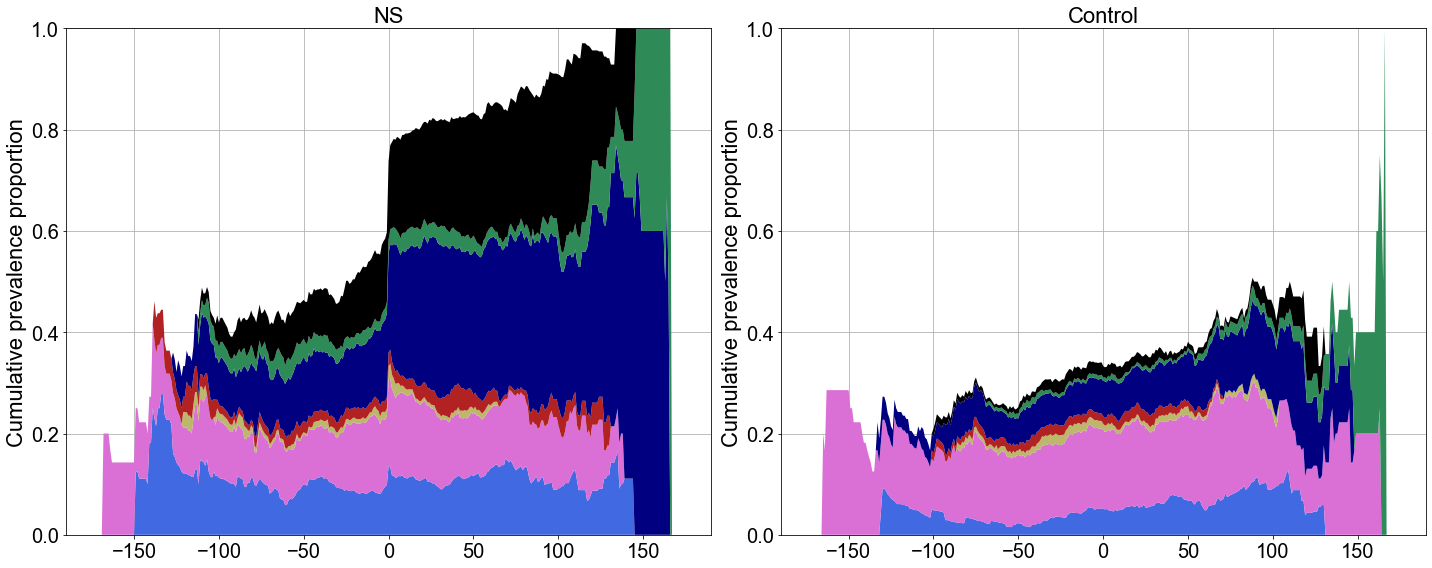

In [7]:

fig, ax = plt.subplots(ncols=2, figsize=[20,8], sharex=True)
mpl.rcParams['savefig.edgecolor']= '#ffffff'
mpl.rcParams['savefig.facecolor']= '#ffffff'
mpl.rcParams['axes.facecolor']='#ffffff'
mpl.rcParams['axes.facecolor']='#ffffff'
mpl.rcParams['grid.alpha'] = 0.5
plt.grid(visible=True)

# For cumulative prevalence among I10*E78*E79
for group in ["Case", "Control"]:
    if group=="Case": i=0
    elif group=="Control": i=1
    ax[i].stackplot(df_ratio.index, 
             df_ratio[group]["I10"] - df_ratio[group]["I10*E78"] - df_ratio[group]["I10*E79"] + df_ratio[group]["I10*E78*E79"], # I10 without combinations
             df_ratio[group]["E78"] - df_ratio[group]["I10*E78"] - df_ratio[group]["E78*E79"] + df_ratio[group]["I10*E78*E79"], # E78 without combinations
             df_ratio[group]["E79"] - df_ratio[group]["E78*E79"] - df_ratio[group]["I10*E79"] + df_ratio[group]["I10*E78*E79"], # E79 without combinations
             df_ratio[group]["E78*E79"] - df_ratio[group]["I10*E78*E79"],  # E78*E79 without I10 
             df_ratio[group]["I10*E78"] - df_ratio[group]["I10*E78*E79"],  # I10*E78 without E79
             df_ratio[group]["I10*E79"] - df_ratio[group]["I10*E78*E79"],  # I10*E79 without E78
             df_ratio[group]["I10*E78*E79"],
             labels=["I10", "E78", "E79", "E78*E79", "I10*E78", "I10*E79", "I10*E78*E79"],
             colors = ["royalblue", "orchid", "darkkhaki", "firebrick", "navy", "seagreen", "black"])
    ax[i].set_xlim([-190,190])
    ax[i].set_ylim([0,1])
    ax[i].set_ylabel("Cumulative prevalence proportion", fontsize=22)
    if i == 0: group ="NS"
    ax[i].set_title(f"{group}", fontsize=22)
    ax[i].tick_params(labelsize=20, color = "k")
    ax[i].set_xticks([-150,-100,-50,0,50,100,150])
    ax[i].grid(visible=True)
    ax[i].set_axisbelow(True)
plt.tight_layout()
plt.savefig(output_image_dir+"triad_prevalence.pdf")

In [8]:
# ICD10 codes in English, which was used sed only for checking descriptions, not referenced in code here.
# Dawnloaded from URL: https://www.health.gov.za/icd-10-master-industry-table/
df_cdref = pd.read_excel("/Users/chidakatsuyuki/Desktop/Project/sample/ICD-10_MIT_2021_Excel_16-March_2021.xlsx", 
                          sheet_name = "SA ICD-10 MIT 2021",
                         usecols=["ICD10_3_Code", "ICD10_3_Code_Desc"]
                        ).drop_duplicates()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


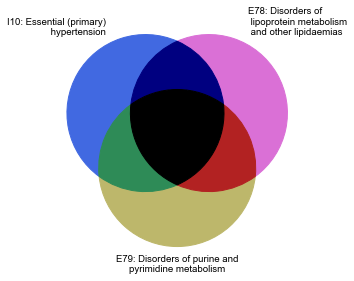

<Figure size 432x288 with 0 Axes>

In [9]:
# Make Venn diagram for colour scheme
fig = plt.figure(figsize=(8,4))

mpl.rcParams["font.size"] = 8
v = venn3(subsets=(1, 1, 1, 1, 1, 1, 1), 
          set_labels = ("I10", "E78", "E79"))
# Descriptions according to labels
descritption = ["Essential (primary)\n hypertension", 
                'Disorders of\n lipoprotein metabolism\n and other lipidaemias',
                "Disorders of purine and\npyrimidine metabolism"]

# Venn diagram setting
text1 = ["I10", "E78", "E79", "E78*E79", "I10*E78", "I10*E79", "I10*E78*E79"]
text2 = ["A", "B", "C", "AB", "BC", "CA", "ABC",]
point = ["100", "010", "001", "011", "110", "101", "111"]
colors = ["royalblue", "orchid", "darkkhaki", "firebrick", "navy", "seagreen", "black"]
for i in range(len(point)):
    v.get_patch_by_id(point[i]).set_alpha(1.0)
    v.get_patch_by_id(point[i]).set_color(colors[i])
    v.get_label_by_id(point[i]).set_text('')
for i in range(3):
    v.get_label_by_id(text2[i]).set_text(f'{text1[i]}: {descritption[i]}')

plt.tight_layout()
plt.show()
plt.savefig(output_image_dir+"venn_triad_prevalence.pdf")

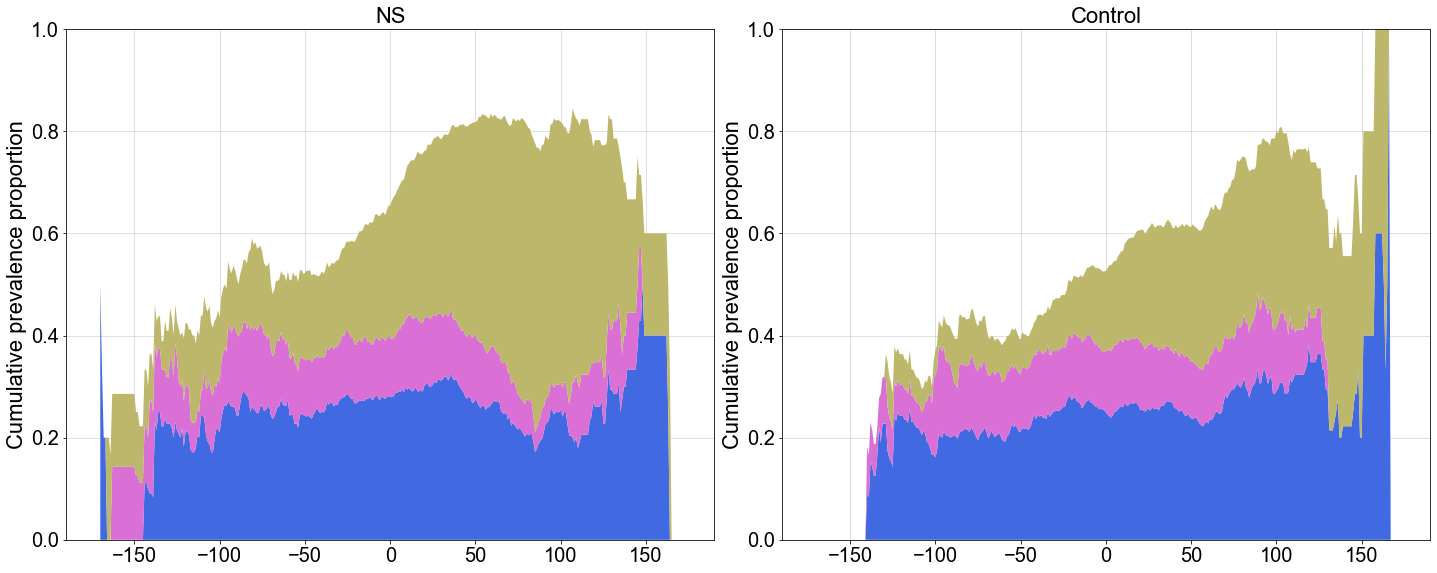

In [10]:
fig, ax = plt.subplots(ncols=2, figsize=[20,8], sharex=True)

# For cumulative prevalence among L30*J30
for group in ["Case", "Control"]:
    if group=="Case": i=0
    elif group=="Control": i=1
    ax[i].stackplot(df_ratio.index, 
             df_ratio[group]["J30"] - df_ratio[group]["L30*J30"], # J30 without L30
             df_ratio[group]["L30"] - df_ratio[group]["L30*J30"], # L30 without J30
             df_ratio[group]["L30*J30"],
             labels=["J30", "L30", "L30*J30"],
             colors = ["royalblue", "orchid", "darkkhaki"])
    ax[i].set_xlim([-190,190])
    ax[i].set_ylim([0,1])
    ax[i].set_ylabel("Cumulative prevalence proportion", fontsize=22)
    if i == 0: group ="NS"
    ax[i].set_title(f"{group}", fontsize=22)
    ax[i].tick_params(labelsize=20, color = "k")
    ax[i].set_xticks([-150,-100,-50,0,50,100,150])
    ax[i].grid(visible=True)
    ax[i].set_axisbelow(True)
plt.tight_layout()
plt.savefig(output_image_dir+"pair_prevalence.pdf")

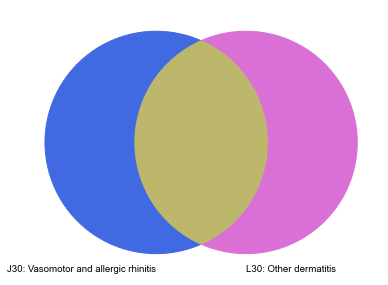

<Figure size 432x288 with 0 Axes>

In [11]:
# Make Venn diagram for colour scheme
v = venn2(subsets=(1, 1, 1), 
          set_labels = ("J30", "L30", "L30*J30"))
# Descriptions according to labels
descritption = ["Essential (primary)\n hypertension", 
                'Disorders of\n lipoprotein metabolism\n and other lipidaemias',
                "Disorders of purine and\npyrimidine metabolism"]
description = ["Vasomotor and allergic rhinitis","Other dermatitis"]
text1 = ["J30", "L30", "L30*J30"]
text2 = ["A", "B"]
point = ["10", "01", "11"]
colors = ["royalblue", "orchid", "darkkhaki"]
temp = "コード名"
for i in range(len(point)):
    v.get_patch_by_id(point[i]).set_alpha(1.0)
    v.get_patch_by_id(point[i]).set_color(colors[i])
    v.get_label_by_id(point[i]).set_text('')
for i in range(2):
    v.get_label_by_id(text2[i]).set_text(f'{text1[i]}: {description[i]}')

plt.tight_layout()
plt.show()
plt.savefig(output_image_dir+"venn_pair_prevalence.pdf")

## Odds calculation

In [12]:
import scipy
from scipy.stats import norm
print("scipy",scipy.__version__)
z_crit = [norm.ppf(0.025), norm.ppf(0.975)]

scipy 1.7.3


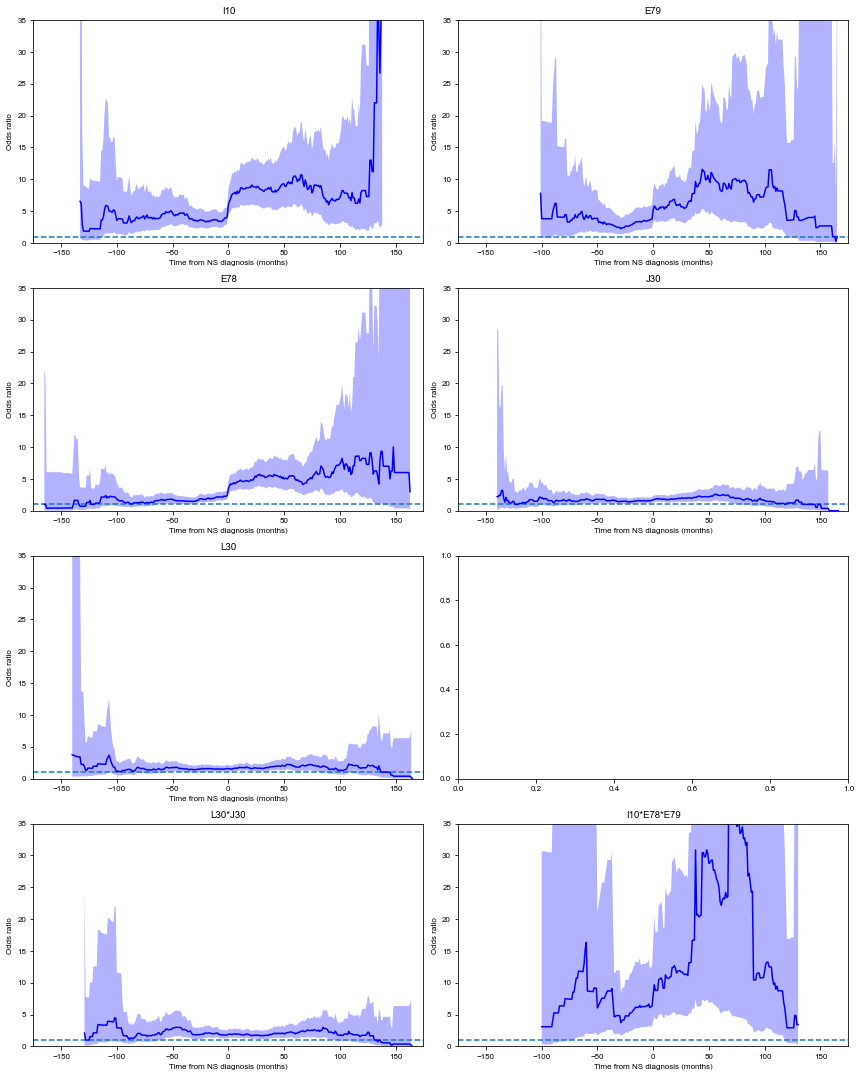

In [13]:
codes = ["I10", "E79", "E78", "J30", "L30"]
code3= codes+["L30*J30","I10*E78*E79"]
df_odds = pd.DataFrame(index=time_points,
                       columns=pd.MultiIndex.from_product((code3,["Odds","Upper","Lower"])))

fig, ax = plt.subplots(4,2,figsize = (12, 15))
ax = ax.ravel()


for i,code in enumerate(code3):
    if i >= 5:
        i=i+1
    # Items in cross table
    a = df_total.T["Case"][code]
    b = df_obsnum["Case"]-df_total.T["Case"][code]
    c = df_total.T["Control"][code]
    d = df_obsnum["Control"]-df_total.T["Control"][code]
    
    # Odds calculation
    df_odds.loc[:,(code,"Odds")] = (a*d)/(b*c)
    df_odds.loc[:,(code,"Upper")] = df_odds.loc[:,(code,"Odds")]*np.exp(z_crit[1]*np.sqrt(1/a+1/d+1/c+1/b))
    df_odds.loc[:,(code,"Lower")] = df_odds.loc[:,(code,"Odds")]*np.exp(z_crit[0]*np.sqrt(1/a+1/d+1/c+1/b))
    
    # Plot
    ax[i].set_ylim([0,35])
    ax[i].hlines(y=1,xmin=-175,xmax=175,linestyles='dashed')
    ax[i].fill_between(df_odds.index, 
                    df_odds.loc[:,(code,"Lower")],
                     df_odds.loc[:,(code,"Upper")],
                    facecolor="blue", alpha=0.3, label='fill')
    ax[i].plot(df_odds.loc[:,(code,"Odds")],c = "blue")
    ax[i].set_ylabel("Odds ratio")
    ax[i].set_title(f"{code}")
    ax[i].set_xlim([-175,175])
    ax[i].set_xlabel("Time from NS diagnosis (months)")
plt.tight_layout()
plt.savefig(output_image_dir+"odds_ratio.pdf")

In [19]:
# Check odds ratio
x= "L30*J30"
df_odds.loc[(-60,-48,-36,-24),(x)] 

,Odds,Upper,Lower
-60,1.888773,3.865218,0.922966
-48,2.933690,5.492772,1.566884
-36,2.306600,3.997505,1.330931
-24,1.885496,2.987725,1.189901


In [18]:
# Check odds ratio
x= "I10*E78*E79"
df_odds.loc[(-60,-48,-36,-24),(x)] 

,Odds,Upper,Lower
-60,16.346154,125.194099,2.134260
-48,6.822866,23.395289,1.989781
-36,6.781377,19.761134,2.327147
-24,4.790933,10.500942,2.185808


## Stratified analysis

In [20]:
# Stratifying by Sex
df_pm = df_p[df_p["Sex"] == "Male"]
df_cm = df_c[df_c["Sex"] == "Male"]

df_pf = df_p[df_p["Sex"] == "Female"]
df_cf = df_c[df_c["Sex"] == "Female"]

# Stratifying by Age_at_start
df_py = df_p[df_p["Age_at_start"] < 40]
df_cy = df_c[df_c["Age_at_start"] < 40]

df_po = df_p[df_p["Age_at_start"] >= 40]
df_co = df_c[df_c["Age_at_start"] >= 40]

# Make a list of keys
keys=["Male","Female","< 40",">= 40"]
#Make a dictionary of stratified data (Control,Case)
dict_strat = {
    "Male":(df_cm,df_pm),
    "Female":(df_cf,df_pf),
    "< 40":(df_cy,df_py),
    ">= 40":(df_co,df_po)
}

In [21]:
# Use dictionary store each stratified dataframe
count_dict = {}

for key in keys:
    count_dict[key] = Set_First_Diag_Point(df_p=dict_strat[key][1], # Case
                                           df_c=dict_strat[key][0]) # Control

In [22]:
# Run same procedures above
comb_dict = {}
for key in keys:
    # For combination
    array = [x for x in itertools.product(["Control"],code2,
                                          dict_strat[key][0]["Enrollee ID"].drop_duplicates())
            ] + [x for x in itertools.product(["Case"],code2,
                                              dict_strat[key][1]["Enrollee ID"].drop_duplicates())
                ]
    column = pd.MultiIndex.from_tuples(array, names=["Group", "Disease", "ID"])
    # Dataframe for counting
    df_comb = pd.DataFrame(index=time_points,columns=column)

    # Count each combination of interest
    for group in ["Control", "Case"]:
        if group == "Control":
            idx = dict_strat[key][0]["Enrollee ID"].drop_duplicates()      
        elif group == "Case":
            idx = dict_strat[key][1]["Enrollee ID"].drop_duplicates()  
        for i in idx:
            df_comb.loc[:,(group,"L30*J30",i)]=df_count.loc[:,(group,"L30",i)]*df_count.loc[:,(group,"J30",i)]
            df_comb.loc[:,(group,"I10*E79",i)]=df_count.loc[:,(group,"I10",i)]*df_count.loc[:,(group,"E79",i)]
            df_comb.loc[:,(group,"I10*E78",i)]=df_count.loc[:,(group,"I10",i)]*df_count.loc[:,(group,"E78",i)]
            df_comb.loc[:,(group,"E78*E79",i)]=df_count.loc[:,(group,"E78",i)]*df_count.loc[:,(group,"E79",i)]
            df_comb.loc[:,(group,"I10*E78*E79",i)]=df_count.loc[:,(group,"I10",i)]*df_comb.loc[:,(group,"E78*E79",i)]
    comb_dict[key]=df_comb

In [23]:
# Counts individuals at time_points for a calculation of ratio
# Individual observation period
obs_dict={}
for key in keys:
    
    df_temp = pd.concat([dict_strat[key][0],dict_strat[key][1]]).drop_duplicates('Enrollee ID')
    # To the observation start from target diagnosis
    df_temp["To_observation_start"]= pd.to_datetime(df_temp["Observation_start_yyyymm"],format='%Y%m').dt.to_period('M').view('int')-pd.to_datetime(
                                            df_temp["Target_diag_yyyymm"],format='%Y%m').dt.to_period('M').view('int')
    # To the observation end from target diagnosis
    df_temp["To_observation_end"] = pd.to_datetime(df_temp["Observation_end_yyyymm"],format='%Y%m').dt.to_period('M').view('int')-pd.to_datetime(
                                            df_temp["Target_diag_yyyymm"],format='%Y%m').dt.to_period('M').view('int')
    df_temp =df_temp[['Enrollee ID','Target','To_observation_start', 'To_observation_end']]
    
    
    df_obsnum = pd.DataFrame(data = {"Time_point":time_points})
    for group in case_con.keys():
        for i in range(len(df_obsnum)-1):
            start_mask = (df_temp["Target"]==case_con[group])&(df_temp["To_observation_start"]<=df_obsnum.loc[i, "Time_point"])
            end_mask = (df_temp["Target"]==case_con[group])&(df_obsnum.loc[i+1, "Time_point"]<=df_temp["To_observation_end"])
            df_obsnum.loc[i, f"{group}"] = (start_mask&end_mask).sum()

        end_mask = (df_temp["Target"]==case_con[group])&(df_obsnum.loc[len(df_obsnum)-1, "Time_point"] <= df["To_observation_end"])
        df_obsnum.loc[len(df_obsnum)-1, f"{group}"] = end_mask.sum()
    df_obsnum.set_index("Time_point",inplace=True)
    
    obs_dict[key]=df_obsnum

In [24]:
total_dict={}
ratio_dict={}
for key in keys:
    # Aggregate counts and then concatenate two dataframes
    total_dict[key] = pd.concat([count_dict[key].T.groupby(level=("Group","Disease")).agg(sum),
                           comb_dict[key].T.groupby(level=("Group","Disease")).agg(sum)]).sort_index()

    # Calculate ratios along with time
    ratio_dict[key] = pd.concat([total_dict[key].loc["Case"]/obs_dict[key]["Case"],
                          total_dict[key].loc["Control"]/obs_dict[key]["Control"]],
                         keys=("Case","Control")).T

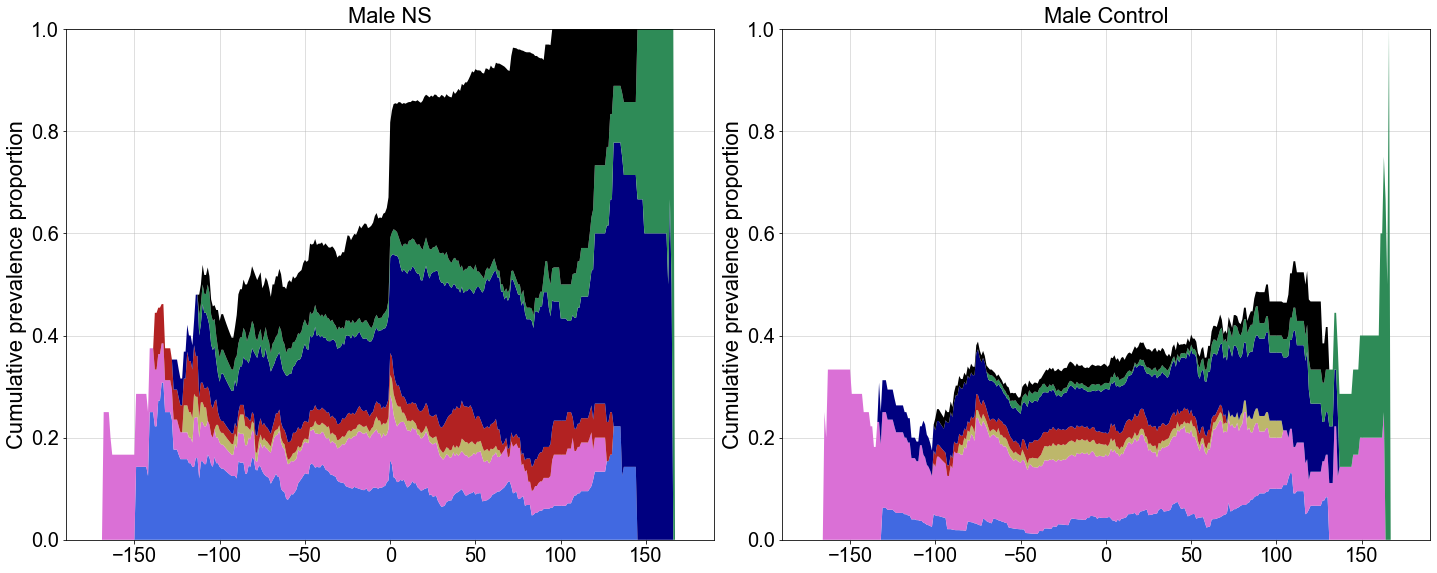

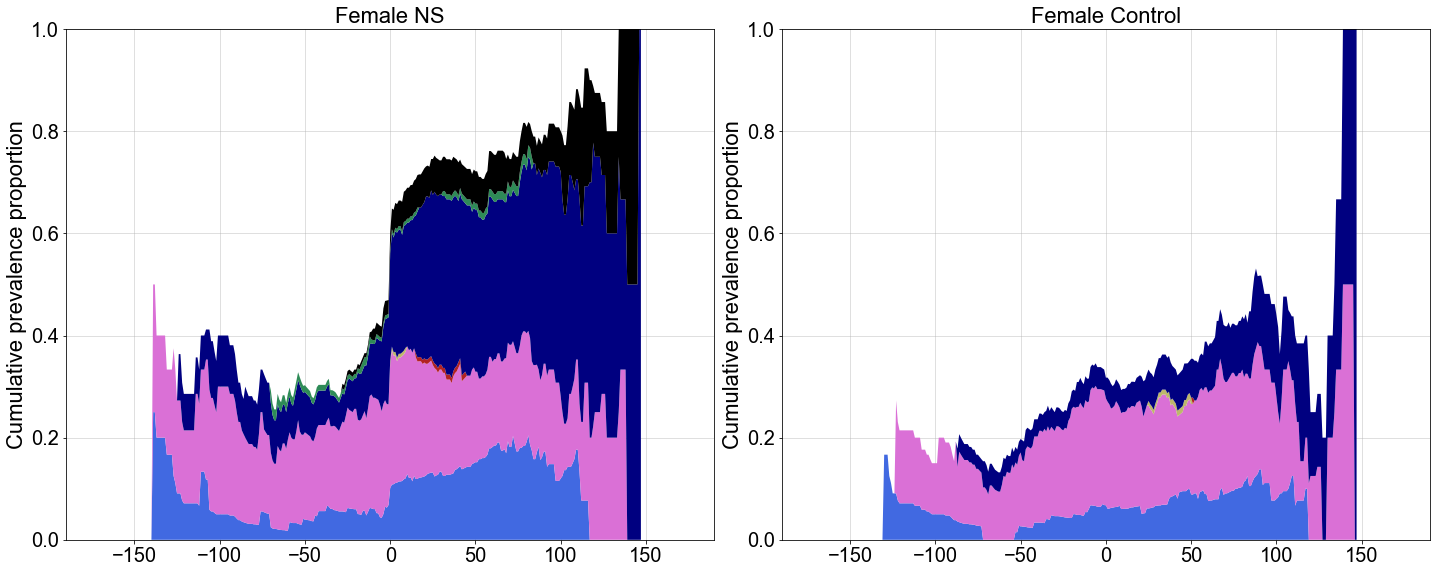

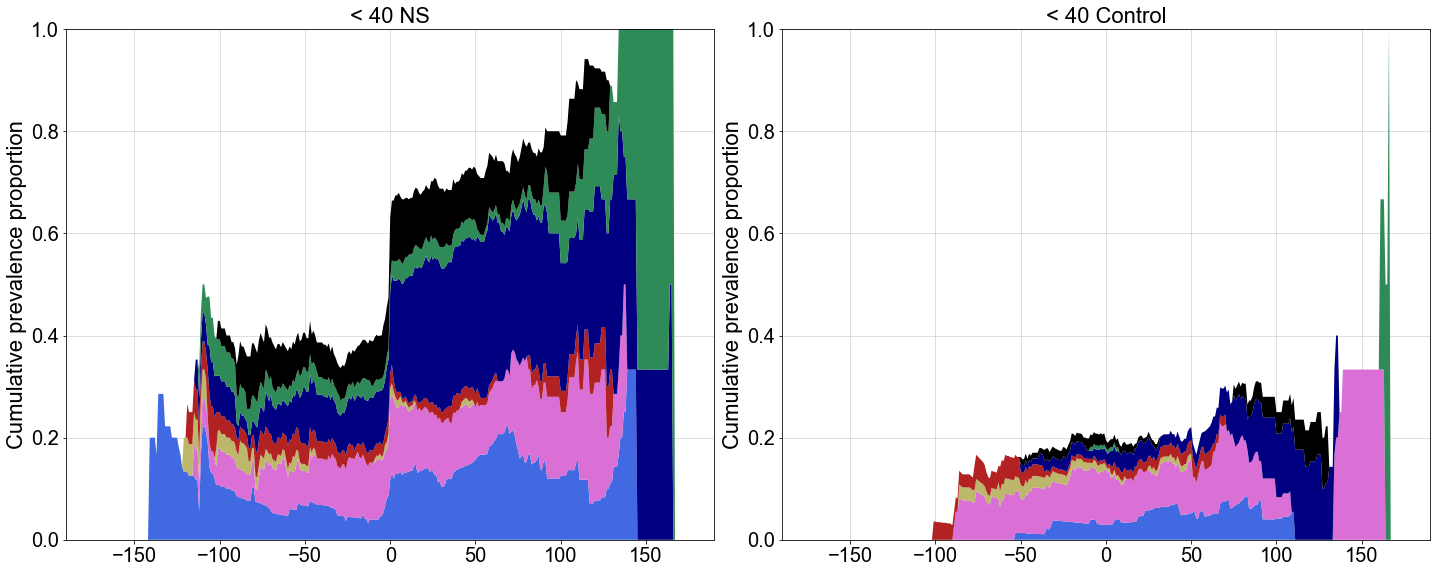

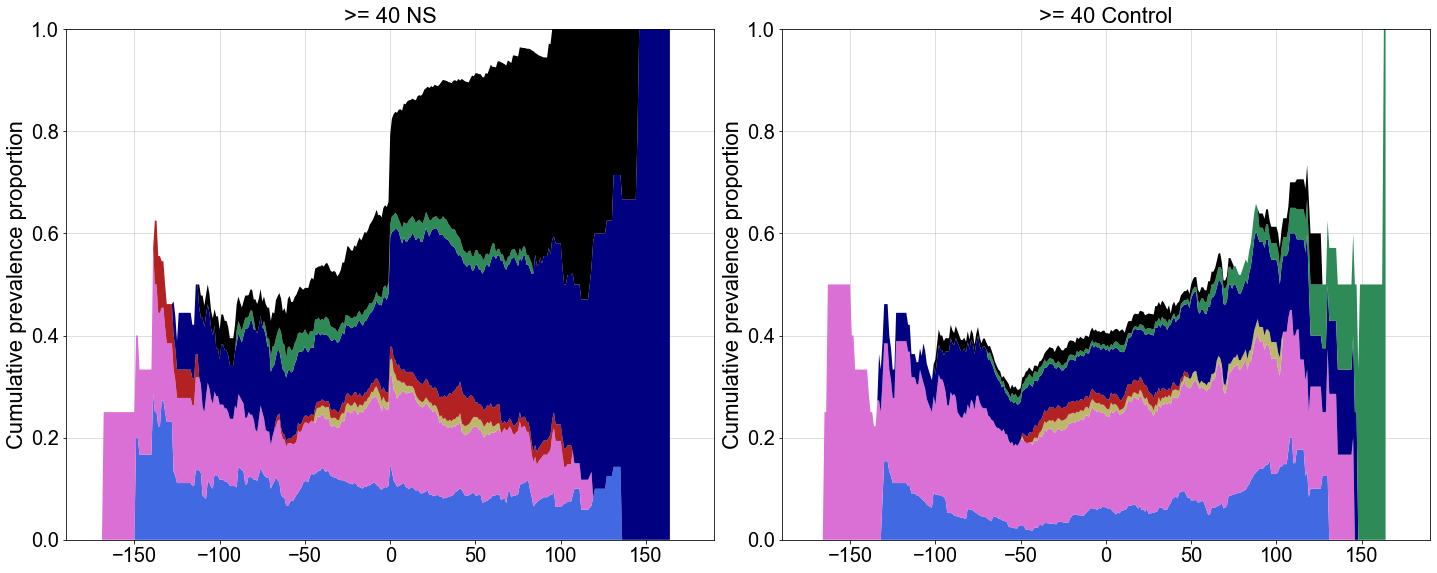

In [25]:
# For cumulative prevalence among I10*E78*E79
for key in keys:
    fig, ax = plt.subplots(ncols=2, figsize=[20,8], sharex=True)
    mpl.rcParams['savefig.edgecolor']= '#ffffff'
    mpl.rcParams['savefig.facecolor']= '#ffffff'
    mpl.rcParams['axes.facecolor']='#ffffff'
    mpl.rcParams['axes.facecolor']='#ffffff'
    mpl.rcParams['grid.alpha'] = 0.5
    plt.grid(visible=True)
    for group in ["Case", "Control"]:
        if group=="Case": i=0
        elif group=="Control": i=1
        ax[i].stackplot(ratio_dict[key].index, 
                 ratio_dict[key][group]["I10"] - ratio_dict[key][group]["I10*E78"] - ratio_dict[key][group]["I10*E79"] + ratio_dict[key][group]["I10*E78*E79"], # I10 without combinations
                 ratio_dict[key][group]["E78"] - ratio_dict[key][group]["I10*E78"] - ratio_dict[key][group]["E78*E79"] + ratio_dict[key][group]["I10*E78*E79"], # E78 without combinations
                 ratio_dict[key][group]["E79"] - ratio_dict[key][group]["E78*E79"] - ratio_dict[key][group]["I10*E79"] + ratio_dict[key][group]["I10*E78*E79"], # E79 without combinations
                 ratio_dict[key][group]["E78*E79"] - ratio_dict[key][group]["I10*E78*E79"],  # E78*E79 without I10 
                 ratio_dict[key][group]["I10*E78"] - ratio_dict[key][group]["I10*E78*E79"],  # I10*E78 without E79
                 ratio_dict[key][group]["I10*E79"] - ratio_dict[key][group]["I10*E78*E79"],  # I10*E79 without E78
                 ratio_dict[key][group]["I10*E78*E79"],
                 labels=["I10", "E78", "E79", "E78*E79", "I10*E78", "I10*E79", "I10*E78*E79"],
                 colors = ["royalblue", "orchid", "darkkhaki", "firebrick", "navy", "seagreen", "black"])
        ax[i].set_xlim([-190,190])
        ax[i].set_ylim([0,1])
        ax[i].set_ylabel("Cumulative prevalence proportion", fontsize=22)
        if i == 0: group ="NS"
        ax[i].set_title(f"{key} {group}", fontsize=22)
        ax[i].tick_params(labelsize=20, color = "k")
        ax[i].set_xticks([-150,-100,-50,0,50,100,150])
        ax[i].grid(visible=True)
        ax[i].set_axisbelow(True)
    plt.tight_layout()
    plt.savefig(output_image_dir+f"{key}triad_prevalence.pdf")

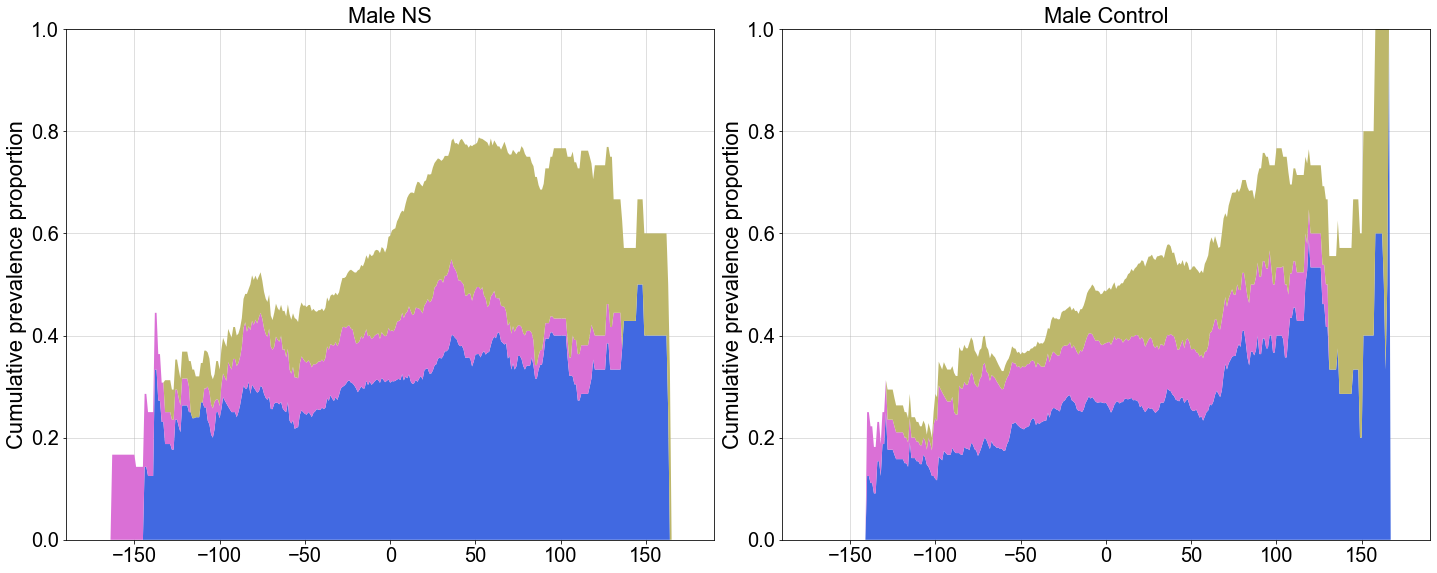

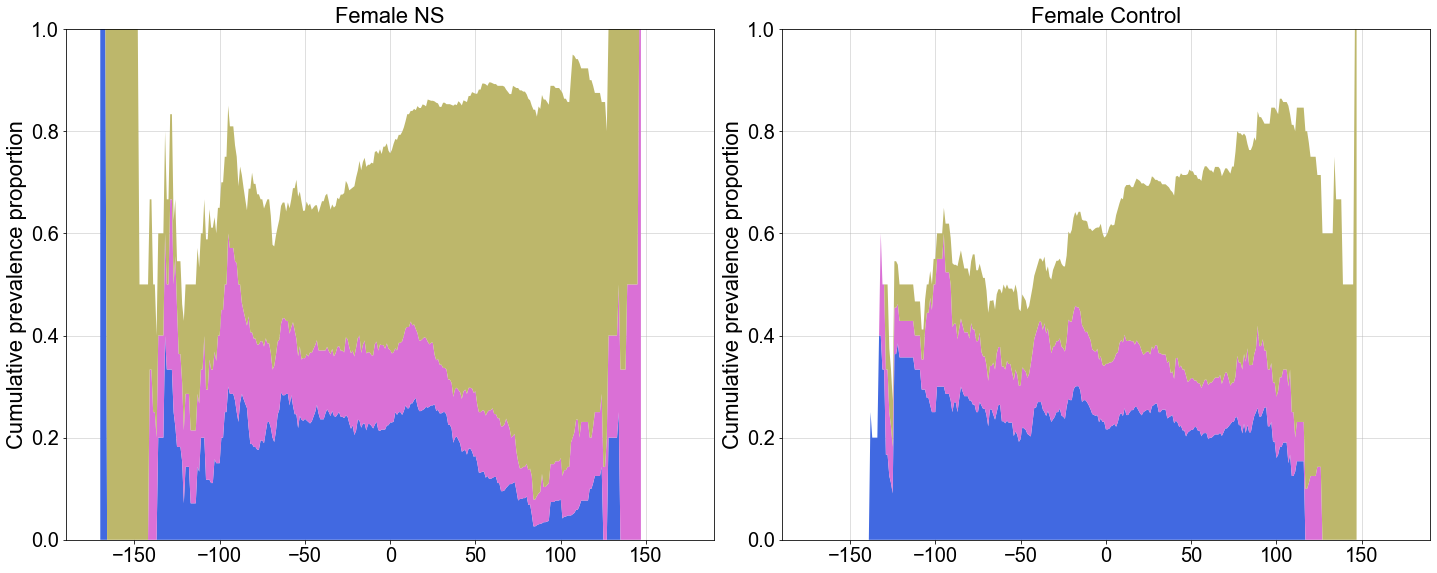

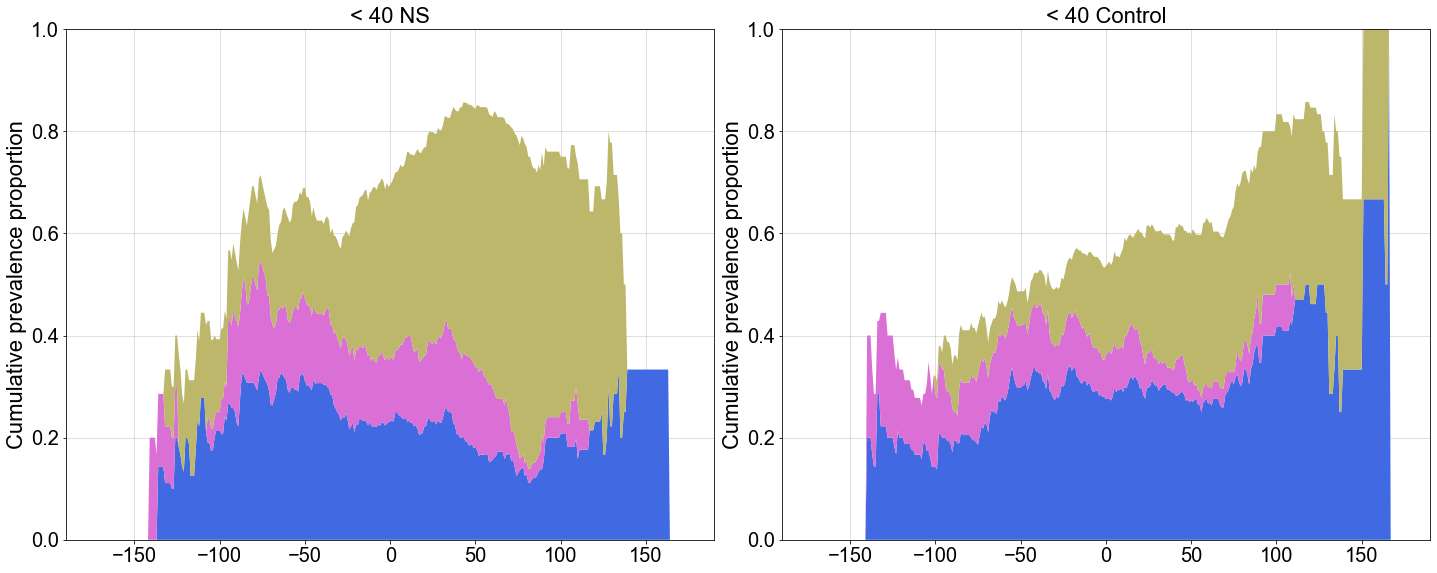

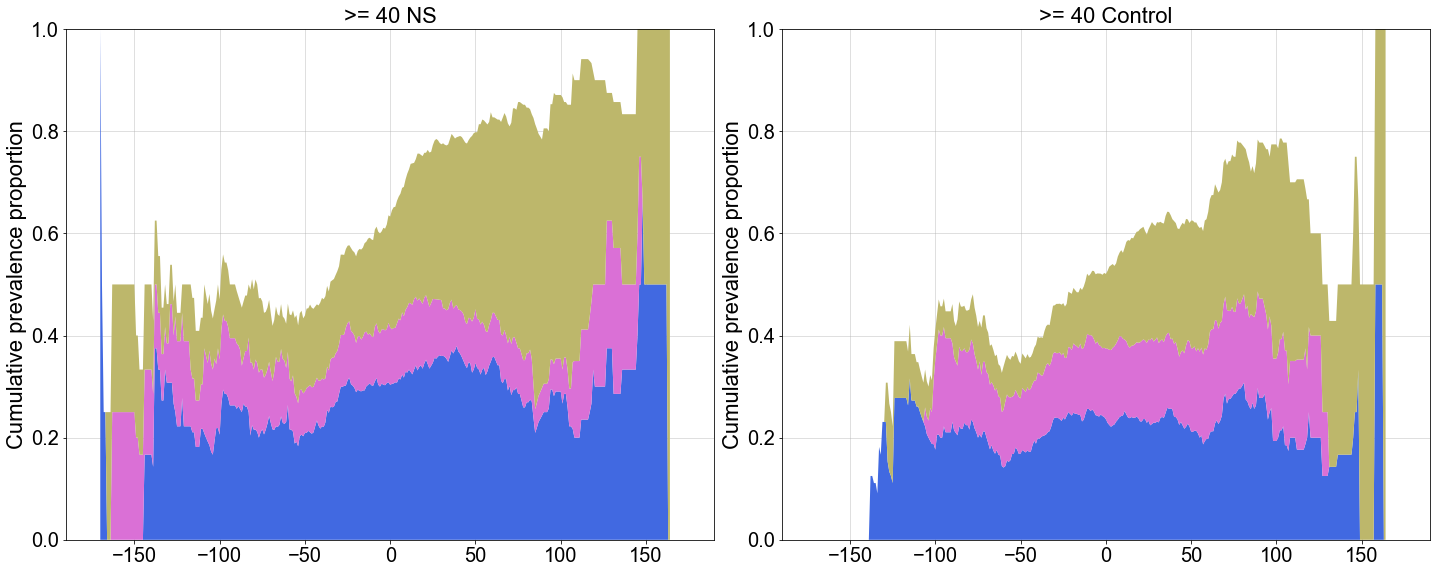

In [26]:
# For cumulative prevalence among L30*J30
for key in keys:
    fig, ax = plt.subplots(ncols=2, figsize=[20,8], sharex=True)
    
    for group in ["Case", "Control"]:
        if group=="Case": i=0
        elif group=="Control": i=1
        ax[i].stackplot(ratio_dict[key].index, 
                 ratio_dict[key][group]["J30"] - ratio_dict[key][group]["L30*J30"], # J30 without L30
                 ratio_dict[key][group]["L30"] - ratio_dict[key][group]["L30*J30"], # L30 without J30
                 ratio_dict[key][group]["L30*J30"],
                 labels=["J30", "L30", "L30*J30"],
                 colors = ["royalblue", "orchid", "darkkhaki"])
        ax[i].set_xlim([-190,190])
        ax[i].set_ylim([0,1])
        ax[i].set_ylabel("Cumulative prevalence proportion", fontsize=22)
        if i == 0: group ="NS"
        ax[i].set_title(f"{key} {group}", fontsize=22)
        ax[i].tick_params(labelsize=20, color = "k")
        ax[i].set_xticks([-150,-100,-50,0,50,100,150])
        ax[i].grid(visible=True)
        ax[i].set_axisbelow(True)
    plt.tight_layout()
    plt.savefig(output_image_dir+f"{key}_pair_prevalence.pdf")